In [1]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, concatenate, Embedding, LSTM, Dense, Activation, Dropout
from keras.callbacks import EarlyStopping

from keras.utils import np_utils, plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

import numpy as np
import pandas as pd

from datetime import datetime,timedelta
import matplotlib.pyplot as plt

Using TensorFlow backend.
/Users/Kuki/.pyenv/versions/anaconda3-4.4.0/envs/keras/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Load Data

* MSM
* 平塚塔観測データ
* 気象庁観測データ
* 海洋ブイ

In [2]:
def get_msm_data(year, lat, lon, data):
    csv_dir_path = "../data/csv"
    file_path="{0}/{1}/{2}".format(csv_dir_path, lon, lat)
    file_name="{0}/{1}_{2}_{3}_{4}.csv".format(file_path, lon, lat, data, year)
    data = np.genfromtxt(file_name, delimiter=",", dtype='float')
    return data[:,1]


lats = ["35.10", "35.15", "35.20", "35.25", "35.30", "35.35", "35.40", "35.45", "35.50"]
lons = ["139.1250", "139.1875", "139.2500", "139.3125", "139.3750", "139.4375", "139.5000", "139.5625", "139.6250"]
data_names = ["UGRD", "VGRD", "TMP", "RH", "PRMSL", "PRES", "APCP"]
data_msm = pd.DataFrame()
for year in range(2013, 2017 + 1):
    data_msm_year = pd.DataFrame()
    data_msm_year["time"] = pd.date_range('{0}-07-01 9:00:00'.format(year), periods=1488, freq='H')
    for lat in lats:
        for lon in lons:
            for data_name in data_names:
                data_msm_year["{0}_{1}_{2}".format(data_name, lat, lon)] = get_msm_data(year, lat, lon, data_name)
    data_msm = pd.concat([data_msm, data_msm_year])
data_msm = data_msm.reset_index(drop=True)

In [3]:
avg_10min_data_path = "../data/hiratsuka/avg_10min"
data_hiratsuka = pd.DataFrame()
for year in range(2013, 2017 + 1):
    data_path = "{0}/{1}".format(avg_10min_data_path, year)
    data_hiratsuka_year = pd.DataFrame(columns=["UGRD", "VGRD"])
    for month in range(7, 8 + 1):
        for day in range(1, 31 + 1):
            file_name = "{0}{1:02d}{2:02d}.csv".format(year, month, day)
            file_path = "{0}/{1}".format(data_path, file_name)

            data_day = pd.read_csv(file_path, header=0)
            data_hiratsuka_year = pd.concat([data_hiratsuka_year, data_day[["UGRD", "VGRD"]]])
            
    data_hiratsuka_year["time"] = pd.date_range('{0}-07-01 00:00:00'.format(year), periods=8928 ,freq='10min')
    data_hiratsuka = pd.concat([data_hiratsuka, data_hiratsuka_year])
data_hiratsuka = data_hiratsuka.reset_index(drop = True)
data_hiratsuka.columns = ["UGRD_hiratsuka", "VGRD_hiratsuka", "time"]
data_hiratsuka = data_hiratsuka[["time", "UGRD_hiratsuka", "VGRD_hiratsuka"]]

In [157]:
kishocho_data_path = "../data/kishocho"
locations = ["hiratsuka", "odawara", "tsujido"]
skiprow_counts = [5, 6, 6] # csvのheader行数
colmns = [[0,1], [0,1,4,7,10,12], [0,1,4,7,10,12]]
colmn_names = [["time", "rain"], ["time", "tmp", "rain", "sun", "wind_vel", "wind_dir"], ["time", "tmp", "rain", "sun", "wind_vel", "wind_dir"]]

wind_dir = ["N", "NNE", "NE", "ENE", "E", "ESE", "SE", "SSE", "S", "SSW", "SW", "WSW", "W", "WNW", "NW", "NNW", "Q"]

wind_dir_class = pd.DataFrame([wind_dir, np.arange(0, len(wind_dir)).tolist()]).T
wind_dir_class.columns = ["wind_dir", "wind_dir_class"]

data = {}
for loc, skiprows, cols, col_name in zip(locations, skiprow_counts, colmns, colmn_names):
    df = pd.DataFrame()
    for year in range(2013, 2017 + 1):
        file_path = "{0}/{1}/{1}_{2}.csv".format(kishocho_data_path, loc, year)
        df = pd.concat([df, pd.read_csv(file_path, skiprows=skiprows, header=None)[cols]])
    df.columns = col_name
    df = df.reset_index(drop = True)
    if loc != "hiratsuka":
        df["sun"] = df["sun"].fillna(0) # 夜間日照時間をnanから0へ
        df_wind = pd.DataFrame(np_utils.to_categorical(pd.merge(df, wind_dir_class)["wind_dir_class"], 17)) # 風向きをクラスに
        df_wind.columns = wind_dir
        df = pd.concat([df, df_wind], axis 
        df = df.drop("wind_dir", axis=1)
    df["time"] = pd.to_datetime(df["time"])
    data[loc] = df
data_kishocho = data
a

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [148]:
df = pd.merge(df, wind_dir_class) 

,0,1
0,N,0
1,NNE,1
2,NE,2
3,ENE,3
4,E,4
5,ESE,5
6,SE,6
7,SSE,7
8,S,8
9,SSW,9


# Network

In [13]:
def plot_wind(data_array, column_array, label_array, start=None, end=None):
    
    fig = plt.figure(figsize=(18, 12), dpi=80)
    ax1 = fig.add_subplot(2,1,1)
    
    if start is not None and end is not None:
        data_array_ = []
        for data in data_array:
            data_ = data.query('time >= \"{0}\" & time < \"{1}\"'.format(start, end))
            data_array_.append(data_)
        data_array = data_array_
    
    for (data, column, label) in zip(data_array, column_array, label_array) :
        ax1.plot(data["time"], data[column], label = label)

    plt.legend()
    plt.show()

# RNN

In [51]:
def addSuffixTo(cols, suffix):
    c = []
    for col in cols:
        if col == "time":
            c.append(col)
        else:
            c.append("{0}_{1}".format(col, suffix))
    return c


step = 10
msm_first = -3
predict_hour = 1

# hiratsuka
time_series_hiratsuka = data_hiratsuka.copy()
time_series_hiratsuka.columns = addSuffixTo(time_series_hiratsuka.columns, 0)
for i in range(1, step):
    data_hiratsuka_ = data_hiratsuka.copy()
    data_hiratsuka_.columns = addSuffixTo(data_hiratsuka_.columns, i)
    data_hiratsuka_["time"] = data_hiratsuka_["time"] + timedelta(minutes=10*i)
    time_series_hiratsuka = pd.merge(time_series_hiratsuka, data_hiratsuka_, on="time", how="outer").sort_values(by="time")
time_series_hiratsuka_col = time_series_hiratsuka.columns

# MSM
# time_series_msm = data_msm.copy()
# time_series_msm.columns = addSuffixTo(time_series_msm.columns, 0)
time_series_msm = pd.DataFrame(data_msm["time"])
for i in range(msm_first, msm_first + step):
    data_msm_ = data_msm.copy()
    data_msm_.columns = addSuffixTo(data_msm_.columns, i)
    data_msm_["time"] = data_msm_["time"] + timedelta(hours=i)
    time_series_msm = pd.merge(time_series_msm, data_msm_, on="time", how="outer").sort_values(by="time")
time_series_msm_col = time_series_msm.columns





    
# MSMのデータを10分おきに複製
date_range = pd.Series()
for year in range(2013, 2018):
    date_range = pd.concat([date_range, pd.Series(pd.date_range('{0}-07-01 09:00:00'.format(year), periods=int(time_series_msm.shape[0]/5*6) ,freq='10min'))])
time_series_msm_amp = pd.concat([time_series_msm, time_series_msm, time_series_msm, time_series_msm, time_series_msm, time_series_msm]).sort_values(by="time")
time_series_msm_amp["time"] = np.array(date_range)
time_series_msm_amp = time_series_msm_amp.reset_index(drop=True)
time_series_msm_amp



# concat
data = pd.merge(time_series_msm_amp, time_series_hiratsuka, how='outer').sort_values(by="time")
data["time_"] = data["time"] + timedelta(hours=predict_hour)
data_hiratsuka_ = data_hiratsuka.copy()
data_hiratsuka_.columns = ["time_", "UGRD", "VGRD"]
data = pd.merge(data, data_hiratsuka_, on="time_")

data = data.dropna()
data

,time,UGRD_35.10_139.1250_-3,VGRD_35.10_139.1250_-3,TMP_35.10_139.1250_-3,RH_35.10_139.1250_-3,PRMSL_35.10_139.1250_-3,PRES_35.10_139.1250_-3,APCP_35.10_139.1250_-3,UGRD_35.10_139.1875_-3,VGRD_35.10_139.1875_-3,...,VGRD_hiratsuka_6,UGRD_hiratsuka_7,VGRD_hiratsuka_7,UGRD_hiratsuka_8,VGRD_hiratsuka_8,UGRD_hiratsuka_9,VGRD_hiratsuka_9,time_,UGRD,VGRD
108,2013-07-01 18:00:00,-1.249200,2.64945,295.595,79.6818,101483.0,100672.0,0.0,-1.31952,3.54007,...,3.626284,0.920817,4.055851,0.684657,4.041670,0.468202,4.256352,2013-07-01 19:00:00,0.432320,3.108554
109,2013-07-01 18:10:00,-1.249200,2.64945,295.595,79.6818,101483.0,100672.0,0.0,-1.31952,3.54007,...,3.395861,0.676285,3.626284,0.920817,4.055851,0.684657,4.041670,2013-07-01 19:10:00,0.591484,3.005560
110,2013-07-01 18:20:00,-1.249200,2.64945,295.595,79.6818,101483.0,100672.0,0.0,-1.31952,3.54007,...,3.664181,0.607828,3.395861,0.676285,3.626284,0.920817,4.055851,2013-07-01 19:20:00,0.549258,2.976018
111,2013-07-01 18:30:00,-1.249200,2.64945,295.595,79.6818,101483.0,100672.0,0.0,-1.31952,3.54007,...,4.314921,0.241923,3.664181,0.607828,3.395861,0.676285,3.626284,2013-07-01 19:30:00,0.973266,3.246565
112,2013-07-01 18:40:00,-1.249200,2.64945,295.595,79.6818,101483.0,100672.0,0.0,-1.31952,3.54007,...,4.446774,-0.043109,4.314921,0.241923,3.664181,0.607828,3.395861,2013-07-01 19:40:00,1.373168,3.297549
113,2013-07-01 18:50:00,-1.249200,2.64945,295.595,79.6818,101483.0,100672.0,0.0,-1.31952,3.54007,...,3.777932,-0.061778,4.446774,-0.043109,4.314921,0.241923,3.664181,2013-07-01 19:50:00,1.088546,3.202804
114,2013-07-01 19:00:00,-1.123600,2.51332,295.345,78.8690,101482.0,100678.0,0.0,-1.60797,3.52894,...,3.455538,0.252662,3.777932,-0.061778,4.446774,-0.043109,4.314921,2013-07-01 20:00:00,0.591190,2.624136
115,2013-07-01 19:10:00,-1.123600,2.51332,295.345,78.8690,101482.0,100678.0,0.0,-1.60797,3.52894,...,3.445960,0.351575,3.455538,0.252662,3.777932,-0.061778,4.446774,2013-07-01 20:10:00,0.717556,2.567971
116,2013-07-01 19:20:00,-1.123600,2.51332,295.345,78.8690,101482.0,100678.0,0.0,-1.60797,3.52894,...,3.350522,0.329396,3.445960,0.351575,3.455538,0.252662,3.777932,2013-07-01 20:20:00,0.946005,2.713874
117,2013-07-01 19:30:00,-1.123600,2.51332,295.345,78.8690,101482.0,100678.0,0.0,-1.60797,3.52894,...,3.092545,0.292876,3.350522,0.329396,3.445960,0.351575,3.455538,2013-07-01 20:30:00,0.979715,2.637207


In [53]:
rnn_msm.shape

(43530, 6237)

In [54]:
def removeCol(col, cols):
    return [x for x in cols if x != "time"]
    
rnn_hiratsuka = np.array(data[removeCol("time", time_series_hiratsuka)])
rnn_hiratsuka = rnn_hiratsuka.reshape(rnn_hiratsuka.shape[0], step, int(rnn_hiratsuka.shape[1]/step))
rnn_msm = np.array(data[removeCol("time", time_series_msm)])
rnn_msm = rnn_msm.reshape(rnn_msm.shape[0], step, int(rnn_msm.shape[1]/step))

In [55]:
rnn_msm.shape, rnn_hiratsuka.shape, data[["time", "UGRD", "VGRD"]].shape

((43554, 10, 567), (43554, 10, 2), (43554, 3))

In [56]:
start_2017 = datetime(2017,7,1,0,0,0)
train_data = data.query('time < \"{0}\" '.format(start_2017))
test_data = data.query('time >= \"{0}\" '.format(start_2017))
idx = train_data.shape[0]

y = np.array(data[["UGRD", "VGRD"]])

train_x_msm = rnn_msm[0:idx, ::-1 ,:]
train_x_hiratsuka = rnn_hiratsuka[0:idx, ::-1 ,:]
train_y = y[0:idx, :]

test_x_msm = rnn_msm[idx:, ::-1 ,:]
test_x_hiratsuka = rnn_hiratsuka[idx:, ::-1 ,:]
test_y = y[idx:, :]

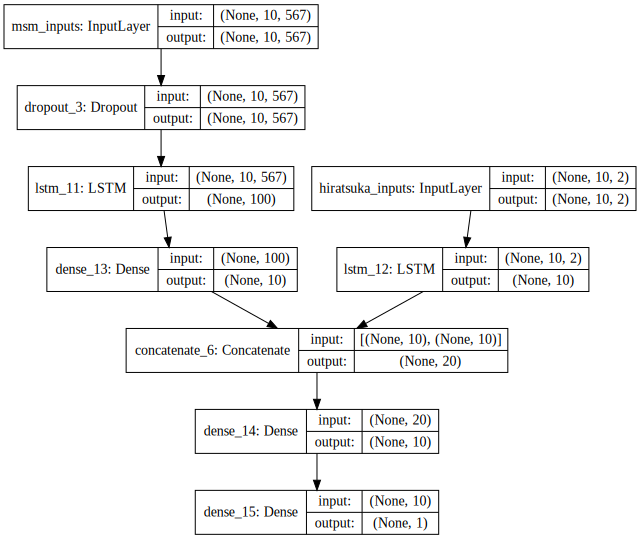

In [57]:
msm_inputs = Input(shape=rnn_msm.shape[1:2+1], name="msm_inputs")
hiratsuka_inputs = Input(shape=rnn_hiratsuka.shape[1:2+1], name="hiratsuka_inputs")

msm = Dropout(0.2)(msm_inputs)
msm = LSTM(100)(msm)
msm = Dense(10, activation='relu')(msm)

hiratsuka = LSTM(10)(hiratsuka_inputs)

m = concatenate([msm, hiratsuka], axis=1)
m = Dense(10, activation='relu')(m)

predictions = Dense(1)(m)

model = Model(inputs=[msm_inputs, hiratsuka_inputs], outputs=predictions)

model.compile(optimizer='adam',
              loss='mse',
             )
SVG(model_to_dot(model, show_shapes = True).create(prog='dot', format='svg'))


In [58]:
callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
history = model.fit([train_x_msm, train_x_hiratsuka], train_y[:,0],
                    batch_size=1024,
                    epochs=1000,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[callback]
                   )

Train on 31266 samples, validate on 3474 samples
Epoch 1/1000
31266/31266 [==============================] - 13s 420us/step - loss: 7.9086 - val_loss: 9.4536
Epoch 2/1000
31266/31266 [==============================] - 11s 342us/step - loss: 6.6922 - val_loss: 8.2543
Epoch 3/1000
31266/31266 [==============================] - 11s 344us/step - loss: 5.6972 - val_loss: 7.1798
Epoch 4/1000
31266/31266 [==============================] - 11s 343us/step - loss: 4.7212 - val_loss: 6.4017
Epoch 5/1000
31266/31266 [==============================] - 11s 342us/step - loss: 3.8814 - val_loss: 5.4400
Epoch 6/1000
31266/31266 [==============================] - 11s 341us/step - loss: 3.2288 - val_loss: 4.7946
Epoch 7/1000
31266/31266 [==============================] - 11s 342us/step - loss: 2.8832 - val_loss: 4.4572
Epoch 8/1000
31266/31266 [==============================] - 11s 342us/step - loss: 2.6942 - val_loss: 4.2609
Epoch 9/1000
31266/31266 [==============================] - 11s 344us/step - lo

2.50153256055
2.17081510496


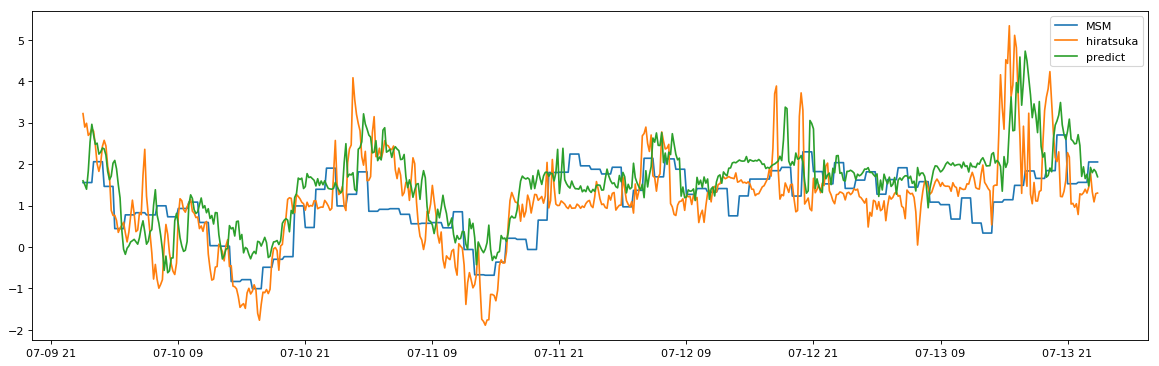

In [62]:
start = datetime(2017,7,10,0,0,0)
end = start + timedelta(days=4)
data_1 = test_data[["time", "UGRD_35.30_139.3750_0"]]
data_2 = test_data[["time", "UGRD_hiratsuka_0"]]
data_3 = pd.DataFrame()
data_3["time"] =  test_data["time"] + timedelta(hours=predict_hour)
data_3["predict"] = model.predict([test_x_msm, test_x_hiratsuka])

print(mean_squared_error(test_x_hiratsuka[:,-1,0], test_y[:,0]))
print(mean_squared_error(model.predict([test_x_msm, test_x_hiratsuka]), test_y[:,0]))
plot_wind([data_1, data_2, data_3], ["UGRD_35.30_139.3750_0", "UGRD_hiratsuka_0", "predict"], ["MSM", "hiratsuka", "predict"], start=start, end=end)

In [100]:
dict_time_series_kishocho = {}
# hiratsuka
for loc in locations:
    data_kishocho_loc = data_kishocho[loc]
    time_series_k_loc = data_kishocho_loc.copy()
    time_series_k_loc.columns = addSuffixTo(time_series_k_loc.columns, 0)
    for i in range(1, step):
        data_kishocho_loc_ = data_kishocho_loc.copy()
        data_kishocho_loc_.columns = addSuffixTo(data_kishocho_loc_.columns, i)
        data_kishocho_loc_["time"] = data_kishocho_loc_["time"] + timedelta(hours=i)
        time_series_k_loc = pd.merge(time_series_k_loc, data_kishocho_loc_, on="time", how="outer").sort_values(by="time")
    dict_time_series_kishocho[loc] = time_series_k_loc

# time_series_kishocho_hiratsuka = time_series_kishocho["hiratsuka"]
# time_series_kishocho_odawara = time_series_kishocho["odawara"]
# time_series_kishocho_tsujido = time_series_kishocho["tsujido"]


In [104]:
# 気象庁観測データを10分おきに複製
dict_time_series_kishocho_amp = {}
for loc, ts_data in dict_time_series_kishocho.items():
    date_range = pd.Series()
    for year in range(2013, 2018):
        date_range = pd.concat([date_range, pd.Series(pd.date_range('{0}-07-01 09:00:00'.format(year), periods=int(ts_data.shape[0]/5*6) ,freq='10min'))])
    ts_data_amp = pd.concat([ts_data, ts_data, ts_data, ts_data, ts_data, ts_data]).sort_values(by="time")
    ts_data_amp["time"] = np.array(date_range)
    ts_data_amp = ts_data_amp.reset_index(drop=True)
    dict_time_series_kishocho_amp[loc] = ts_data_amp

In [107]:
dict_time_series_kishocho_amp["odawara"]

,time,tmp_0,rain_0,sun_0,wind_vel_0,wind_dir_0,tmp_1,rain_1,sun_1,wind_vel_1,...,tmp_8,rain_8,sun_8,wind_vel_8,wind_dir_8,tmp_9,rain_9,sun_9,wind_vel_9,wind_dir_9
0,2013-07-01 09:00:00,20.0,0.0,0.0,1.1,SW,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-07-01 09:10:00,20.0,0.0,0.0,1.1,SW,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-07-01 09:20:00,20.0,0.0,0.0,1.1,SW,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-07-01 09:30:00,20.0,0.0,0.0,1.1,SW,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-07-01 09:40:00,20.0,0.0,0.0,1.1,SW,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2013-07-01 09:50:00,20.0,0.0,0.0,1.1,SW,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2013-07-01 10:00:00,19.9,0.0,0.0,0.4,W,20.0,0.0,0.0,1.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2013-07-01 10:10:00,19.9,0.0,0.0,0.4,W,20.0,0.0,0.0,1.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2013-07-01 10:20:00,19.9,0.0,0.0,0.4,W,20.0,0.0,0.0,1.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2013-07-01 10:30:00,19.9,0.0,0.0,0.4,W,20.0,0.0,0.0,1.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 誤差学習

In [51]:
predict = model.predict([test_x_uv, test_x_hiratsuka])

array([[ -3.57125401],
       [ -3.68482065],
       [ -3.74241853],
       ..., 
       [-10.98486519],
       [-11.46307755],
       [-11.00137806]], dtype=float32)

# 昔

In [90]:
predict_hour = 1

# MSMのデータを10分おきに複製
date_range = pd.Series()
for year in range(2013, 2018):
    date_range = pd.concat([date_range, pd.Series(pd.date_range('{0}-07-01 09:00:00'.format(year), periods=8928 ,freq='10min'))])
data_msm_amp = pd.concat([data_msm, data_msm, data_msm, data_msm, data_msm, data_msm]).sort_values(by="time")
data_msm_amp["time"] = np.array(date_range)
data_msm_amp = data_msm_amp.reset_index(drop=True)

data = pd.merge(data_msm_amp, data_hiratsuka, how='outer')
data["time_"] = data["time"] + timedelta(hours=predict_hour)
data_hiratsuka_ = data_hiratsuka.copy()
data_hiratsuka_.columns = ["UGRD", "VGRD", "time_"]
data = pd.merge(data, data_hiratsuka_, on="time_")

data = data.dropna()

In [91]:
start_2017 = datetime(2017,7,1,0,0,0)
train_data = data.query('time < \"{0}\" '.format(start_2017))
test_data = data.query('time >= \"{0}\" '.format(start_2017))

hiratsuka_col = []
hiratsuka_col.append("UGRD_hiratsuka")
hiratsuka_col.append("VGRD_hiratsuka")

uv_col = []
for lat in lats:
    for lon in lons:
        for data_name in ["UGRD", "VGRD"]:
            uv_col.append("{0}_{1}_{2}".format(data_name, lat, lon))
            
tmp_col = []
for lat in lats:
    for lon in lons:
        for data_name in ["TMP"]:
            tmp_col.append("{0}_{1}_{2}".format(data_name, lat, lon))

label_col = ["UGRD", "VGRD"]

train_x_hiratsuka = train_data[hiratsuka_col]
train_x_uv = train_data[uv_col]
train_x_tmp = train_data[tmp_col]
train_y = train_data[label_col]
test_x_hiratsuka = test_data[hiratsuka_col]
test_x_uv = test_data[uv_col]
test_x_tmp = test_data[tmp_col]
test_y = test_data[label_col]

In [92]:
train_x_uv.shape

(34920, 162)

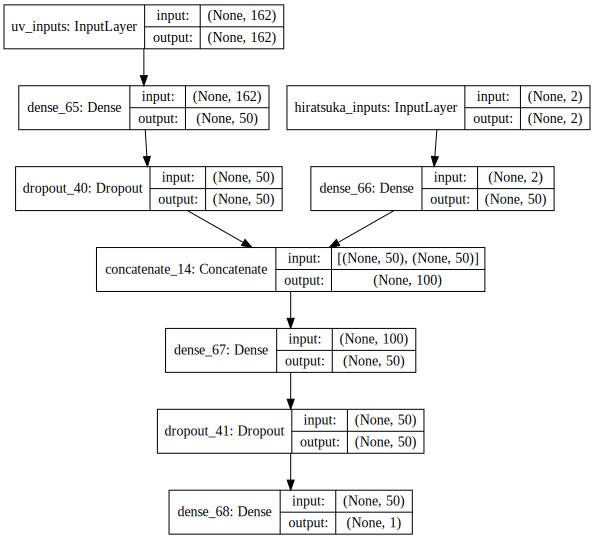

In [100]:
uv_inputs = Input(shape=(train_x_uv.shape[1],), name="uv_inputs")
# tmp_inputs = Input(shape=(train_x_tmp.shape[1],), name="tmp_inputs")
hiratsuka_inputs = Input(shape=(2,), name="hiratsuka_inputs")

# uv = Dropout(0.2)(uv_inputs)
uv = Dense(50, activation='relu')(uv_inputs)
uv = Dropout(0.2)(uv)

# hiratsuka = Dropout(0.2)(hiratsuka_inputs)
hiratsuka = Dense(50, activation='relu')(hiratsuka_inputs)
# hiratsuka = Dropout(0.2)(hiratsuka)

m = concatenate([uv, hiratsuka], axis=1)
m = Dense(50)(m)
m = Dropout(0.5)(m)

predictions = Dense(1)(m)

model = Model(inputs=[uv_inputs, hiratsuka_inputs], outputs=predictions)

model.compile(optimizer='adam',
              loss='mse',
             )
SVG(model_to_dot(model, show_shapes = True).create(prog='dot', format='svg'))

In [101]:
callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
history = model.fit([train_x_uv, train_x_hiratsuka], train_y["VGRD"],
                    batch_size=1024,
                    epochs=1000,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[callback]
                   )

Train on 31428 samples, validate on 3492 samples
Epoch 1/1000
31428/31428 [==============================] - 1s 31us/step - loss: 15.1006 - val_loss: 8.3375
Epoch 2/1000
31428/31428 [==============================] - 0s 6us/step - loss: 5.2906 - val_loss: 5.4424
Epoch 3/1000
31428/31428 [==============================] - 0s 6us/step - loss: 4.4237 - val_loss: 4.7284
Epoch 4/1000
31428/31428 [==============================] - 0s 6us/step - loss: 4.0911 - val_loss: 4.6540
Epoch 5/1000
31428/31428 [==============================] - 0s 6us/step - loss: 3.9298 - val_loss: 4.6778
Epoch 6/1000
31428/31428 [==============================] - 0s 6us/step - loss: 3.8023 - val_loss: 4.5053
Epoch 7/1000
31428/31428 [==============================] - 0s 6us/step - loss: 3.7676 - val_loss: 4.5745
Epoch 8/1000
31428/31428 [==============================] - 0s 6us/step - loss: 3.6943 - val_loss: 4.7946
Epoch 9/1000
31428/31428 [==============================] - 0s 6us/step - loss: 3.6259 - val_loss: 4.

2.77007467851
2.57227067759


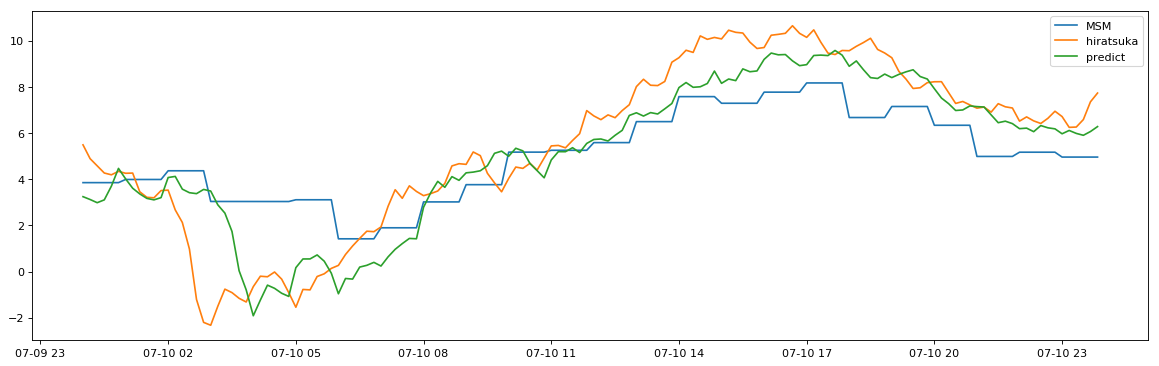

In [104]:
start = datetime(2017,7,10,0,0,0)
end = start + timedelta(days=1)
data_1 = test_data[["time", "VGRD_35.30_139.3750"]]
data_2 = test_data[["time", "VGRD_hiratsuka"]]
data_3 = pd.DataFrame()
data_3["time"] =  test_data["time"] + timedelta(hours=predict_hour)
data_3["predict"] = model.predict([test_x_uv, test_x_hiratsuka])
# data_4 = test_data[["time", "VGRD_hiratsuka"]]
# data_4["time"] = data_4["time"] + timedelta(hours=predict_hour)

# print(mean_squared_error(model.predict([test_x_uv, test_x_hiratsuka]), test_y["VGRD"]))
# plot_wind([data_1, data_2, data_3, data_4], ["VGRD_35.30_139.3750", "VGRD_hiratsuka", "predict", "VGRD_hiratsuka"], ["MSM", "hiratsuka", "predict", "hiratsuka_1h_before"], start=start, end=end)

print(mean_squared_error(test_x_hiratsuka["VGRD_hiratsuka"], test_y["VGRD"]))
print(mean_squared_error(model.predict([test_x_uv, test_x_hiratsuka]), test_y["VGRD"]))
plot_wind([data_1, data_2, data_3], ["VGRD_35.30_139.3750", "VGRD_hiratsuka", "predict"], ["MSM", "hiratsuka", "predict"], start=start, end=end)
